In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import wdtools
import matplotlib.gridspec as gridspec
sp = wdtools.SpecTools()
from scipy.ndimage import gaussian_filter
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58
plt.rcParams.update({'font.size': 18})

import itertools
plt.style.use('vedant')

Holoviews not imported. Some visualizations will not be available.
Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [2]:
lamgrid = np.arange(3200, 9000)
abs_distance = 10 # pc

sigma = 1.5 # Angstrom
convolve = True

## Get MPMS Models

In [3]:
def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, wl):
    return 10**interpsda((logg, teff, np.log10(wl)))

def get_cal_spec_mpms(teff, logg):
    
    mfl = get_sda(teff, logg, lamgrid)

    mfl = mfl / np.pi 

    radius = logg_to_radius(logg) ## CHANGE THIS TO INTERPOLATE ISOCHRONE
    distance = abs_distance * pc_to_m

    solid_angle = (radius / distance) ** 2

    mfl = solid_angle * mfl * 1e-8 #### ADD GP or EXTINCTION?
    
    if convolve:
        mfl = scipy.ndimage.gaussian_filter(mfl, sigma)
    
    return mfl

(3800.0, 6500.0)

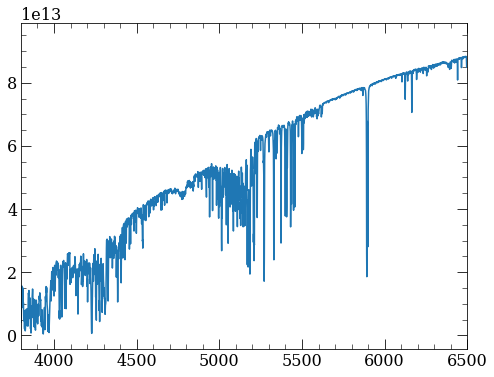

In [4]:
plt.plot(lamgrid, get_sda(3800, 4.5, lamgrid))
plt.xlim(3800, 6500)

## Get WD Models

In [5]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

interpwd = pickle.load(open('interp/interpwd.p', 'rb'))
def get_wd(teff, logg, wl):
    return 10**interpwd((logg, teff, np.log10(wl)))

abs_distance = 10
def get_cal_spec_wd(teff, logg):
    
    mfl = get_wd(teff, logg, lamgrid)

    radius = logg_teff_to_rsun(logg, teff) * radius_sun
    distance = abs_distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl            #### ADD GP or EXTINCTION?
    mfl = 2.99e21 * (mfl/1000) * (1 /lamgrid**2)
    
    if convolve:
        mfl = scipy.ndimage.gaussian_filter(mfl, sigma)
    
    return mfl

### Paper Plot

In [6]:
n_teff = 5
n_logg = 1
teffs = np.linspace(4000, 8000, n_teff)
wd_loggs = np.linspace(8, 8, n_logg)
mpms_loggs = np.linspace(4.5, 4.5, n_logg)
wd_param_grid = np.array(list(itertools.product(teffs, wd_loggs)))
mpms_param_grid = np.array(list(itertools.product(teffs, mpms_loggs)))
print(len(wd_param_grid))

wd_spectra = np.array([get_cal_spec_wd(teff, logg) for teff, logg in wd_param_grid])
mpms_spectra = np.array([get_cal_spec_mpms(teff, logg) for teff, logg in mpms_param_grid])

5


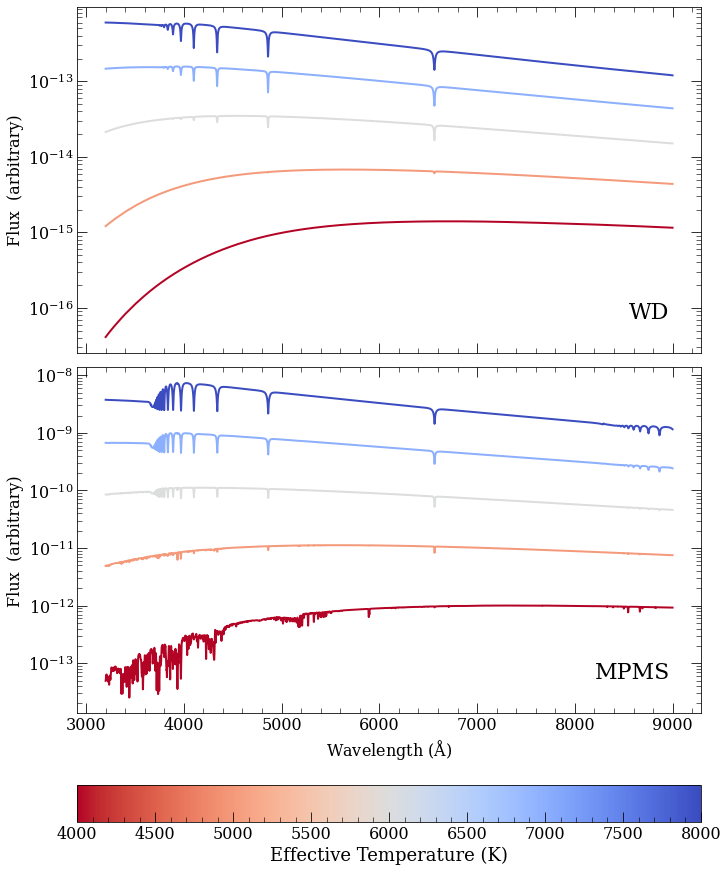

In [11]:
tcmap = plt.cm.coolwarm_r
sm = plt.cm.ScalarMappable(cmap=tcmap , norm=plt.Normalize(vmin=teffs.min(), vmax=teffs.max()))
norm_t = (teffs - teffs.min()) / (teffs.max() - teffs.min())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10, 12), constrained_layout = True)

ax1 = axes[0]

for kk in range(len(wd_spectra)):
    ax1.plot(lamgrid, wd_spectra[kk] * 2 ** kk, alpha = 1, color = tcmap(norm_t[kk]), linewidth = 2);
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.set_ylabel('Flux  (arbitrary)')
ax1.text(0.95, 0.1, 'WD', ha = 'right', transform = ax1.transAxes, fontsize = 22)

ax2 = axes[1]

for kk in range(len(wd_spectra)):
    plt.plot(lamgrid, mpms_spectra[kk] * 3.5 ** kk, alpha = 1, color = tcmap(norm_t[kk]), linewidth = 2);
plt.yscale('log')
plt.text(0.95, 0.1, 'MPMS', ha = 'right', transform = plt.gca().transAxes, fontsize = 22)
plt.ylabel('Flux  (arbitrary)')

cbar = fig.colorbar(sm, ax = axes.flat, orientation = 'horizontal')

cbar.ax.set_xlabel('Effective Temperature (K)', fontsize = 18)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')

plt.savefig('fig/overview.pdf', bbox_inches = 'tight')

In [12]:
n_teff = 5
n_logg = 1
teffs = np.linspace(6000, 8000, n_teff)
wd_loggs = np.linspace(8, 8, n_logg)
mpms_loggs = np.linspace(4.5, 4.5, n_logg)
wd_param_grid = np.array(list(itertools.product(teffs, wd_loggs)))
mpms_param_grid = np.array(list(itertools.product(teffs, mpms_loggs)))
print(len(wd_param_grid))

wd_spectra = np.array([get_cal_spec_wd(teff, logg) for teff, logg in wd_param_grid])
mpms_spectra = np.array([get_cal_spec_mpms(teff, logg) for teff, logg in mpms_param_grid])

5


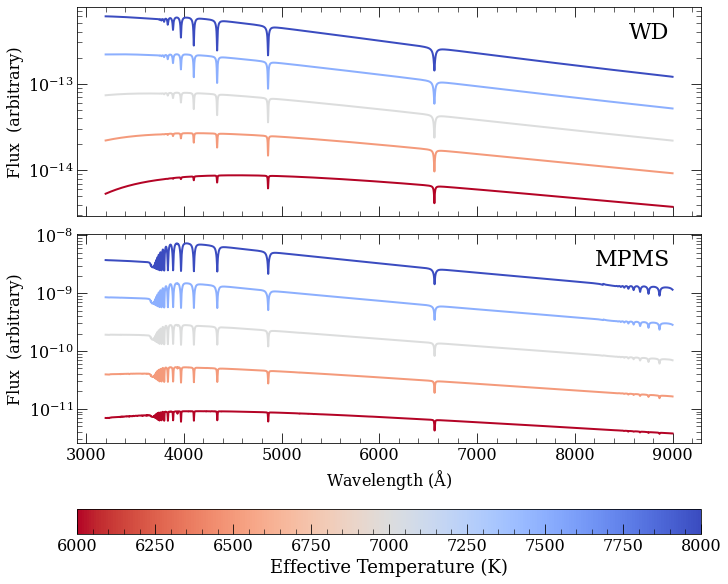

In [15]:
tcmap = plt.cm.coolwarm_r
sm = plt.cm.ScalarMappable(cmap=tcmap , norm=plt.Normalize(vmin=teffs.min(), vmax=teffs.max()))
norm_t = (teffs - teffs.min()) / (teffs.max() - teffs.min())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10, 8), constrained_layout = True)

ax1 = axes[0]

for kk in range(len(wd_spectra)):
    ax1.plot(lamgrid, wd_spectra[kk] * 2 ** kk, alpha = 1, color = tcmap(norm_t[kk]), linewidth = 2);
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.set_ylabel('Flux  (arbitrary)')
ax1.text(0.95, 0.85, 'WD', ha = 'right', transform = ax1.transAxes, fontsize = 22)

ax2 = axes[1]

for kk in range(len(wd_spectra)):
    plt.plot(lamgrid, mpms_spectra[kk] * 3.5 ** kk, alpha = 1, color = tcmap(norm_t[kk]), linewidth = 2);
plt.yscale('log')
plt.text(0.95, 0.85, 'MPMS', ha = 'right', transform = plt.gca().transAxes, fontsize = 22)
plt.ylabel('Flux  (arbitrary)')

cbar = fig.colorbar(sm, ax = axes.flat, orientation = 'horizontal')

cbar.ax.set_xlabel('Effective Temperature (K)', fontsize = 18)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')

plt.savefig('fig/overview_poster.pdf', bbox_inches = 'tight')

# Generate Model Grid

In [9]:
n_teff = 100
n_logg = 5
n_models = n_teff * n_logg

teffs = np.linspace(4000, 8000, n_teff)
wd_loggs = np.linspace(7.05, 9, n_logg)
mpms_loggs = np.linspace(3.5, 5.5, n_logg)

In [10]:
wd_param_grid = np.array(list(itertools.product(teffs, wd_loggs)))
mpms_param_grid = np.array(list(itertools.product(teffs, mpms_loggs)))
print(len(wd_param_grid))

500


In [11]:
wd_spectra = np.array([get_cal_spec_wd(teff, logg) for teff, logg in wd_param_grid])
mpms_spectra = np.array([get_cal_spec_mpms(teff, logg) for teff, logg in mpms_param_grid])

print(sum(np.isnan(wd_spectra[:, 0])))
print(sum(np.isnan(mpms_spectra[:, 0])))

0
0


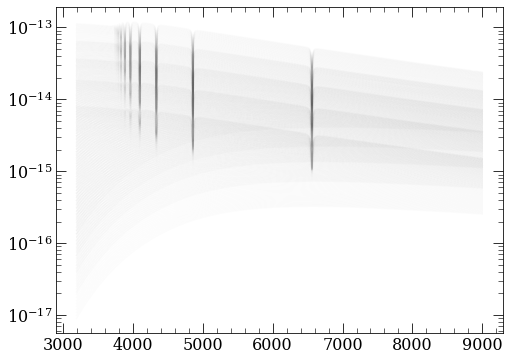

In [12]:
plt.plot(lamgrid, wd_spectra.T, color = 'k', alpha = 0.01);
plt.yscale('log')

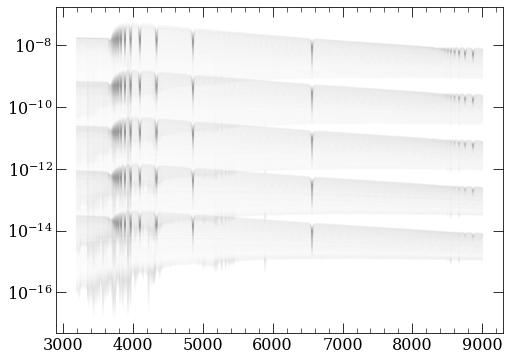

In [13]:
plt.plot(lamgrid, mpms_spectra.T, color = 'k', alpha = 0.01);
plt.yscale('log')

## Get Balmer Parameters

In [14]:
import wdtools
lp = wdtools.LineProfiles()

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
fdf = pd.DataFrame([])

for kk in tqdm(range(n_models)):
    
    wd_spec = wd_spectra[kk]
    mpms_spec = mpms_spectra[kk]
    
    wd_row = lp.fit_balmer(lamgrid, wd_spec, make_plot = False)
    wd_row['mpms'] = 0
    wd_row['teff'] = wd_param_grid[kk][0]
    wd_row['logg'] = wd_param_grid[kk][1]
    
    fdf = fdf.append(wd_row, ignore_index = True)
    
    mpms_row = lp.fit_balmer(lamgrid, mpms_spec, make_plot = False)
    mpms_row['mpms'] = 1
    mpms_row['teff'] = mpms_param_grid[kk][0]
    mpms_row['logg'] = mpms_param_grid[kk][1]
    
    fdf = fdf.append(mpms_row, ignore_index = True)
fulldf = fdf

100%|██████████| 500/500 [01:57<00:00,  4.25it/s]


In [43]:
clean = (
    (fulldf['a_height'] > 0.01)&
    (fulldf['b_height'] > 0.01)&
    (fulldf['g_height'] > 0.01)&
    (fulldf['d_height'] > 0.01)&
    (fulldf['a_fwhm'] < 250)&
    (fulldf['b_fwhm'] < 250)&
    (fulldf['g_fwhm'] < 250)&
    (fulldf['d_fwhm'] < 25)

)

print(len(fulldf[clean]))

722


In [44]:
fdf = fulldf[clean]

In [45]:
np.unique(fdf['logg'])

array([3.5   , 4.    , 4.5   , 5.    , 5.5   , 7.05  , 7.5375, 8.025 ,
       8.5125, 9.    ])

In [46]:
sel_mpms = (fdf['mpms'] == 1)
sel_wd = (fdf['mpms'] == 0)

lowlogg = (fdf['logg'] == 4) | (fdf['logg'] == 7.5375)
midlogg = (fdf['logg'] == 4.5) | (fdf['logg'] == 8.025)
highlogg = (fdf['logg'] == 5) | (fdf['logg'] == 8.5125)

sl_list = [lowlogg, midlogg, highlogg]
width_list = np.array([2, 2.5, 3]) * 2

In [47]:
print(len(fulldf))
len(fdf)

1000


722

In [48]:
sum(fdf['mpms'])

404

## Explore Data

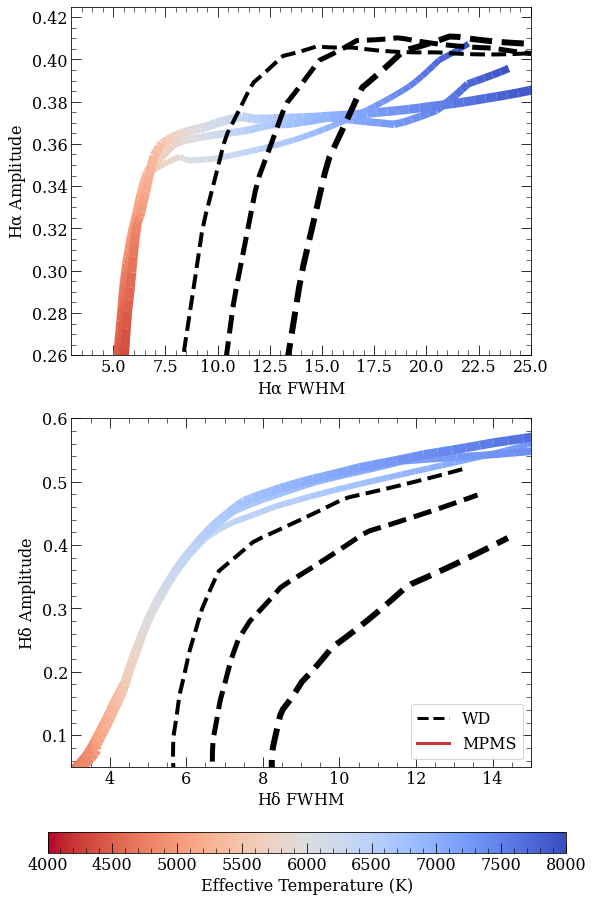

In [50]:
fig, axs = plt.subplots(2, 1, figsize = (8, 12))



for jj in range(3):
    x = np.asarray(fdf['a_fwhm'][sel_mpms & sl_list[jj]])
    y = np.asarray(fdf['a_height'][sel_mpms & sl_list[jj]])
    teff = np.asarray(fdf['teff'][sel_mpms & sl_list[jj]])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(teff.min(), teff.max())
    lc = LineCollection(segments, cmap='coolwarm_r', norm=norm)
    lc.set_array(teff)
    lc.set_linewidth(width_list[jj] * 1.5)
    line = axs[0].add_collection(lc)
    line_args = dict(linewidth = width_list[jj], color = 'k')
    axs[0].plot(fdf['a_fwhm'][sel_wd & sl_list[jj]], fdf['a_height'][sel_wd & sl_list[jj]], 
             linestyle = '--', **line_args)

axs[0].autoscale()
axs[0].set_ylim(0.26, 0.425)
axs[0].set_xlim(3,25)
axs[0].set_xlabel(r'H$\alpha$ FWHM')
axs[0].set_ylabel(r'H$\alpha$ Amplitude')

for jj in range(3):
    x = np.asarray(fdf['d_fwhm'][sel_mpms & sl_list[jj]])
    y = np.asarray(fdf['d_height'][sel_mpms & sl_list[jj]])
    teff = np.asarray(fdf['teff'][sel_mpms & sl_list[jj]])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(4000, 8000)
    lc = LineCollection(segments, cmap='coolwarm_r', norm=norm)
    lc.set_array(teff)
    lc.set_linewidth(width_list[jj] * 1.5)
    line = axs[1].add_collection(lc)
    line_args = dict(linewidth = width_list[jj], color = 'k')
    axs[1].plot(fdf['d_fwhm'][sel_wd & sl_list[jj]], fdf['d_height'][sel_wd & sl_list[jj]], 
             linestyle = '--', **line_args)

axs[1].autoscale()
axs[1].set_xlim(3, 15)
axs[1].set_ylim(0.05, 0.6)
axs[1].set_xlabel(r'H$\delta$ FWHM')
axs[1].set_ylabel(r'H$\delta$ Amplitude')
cmap = plt.cm.coolwarm_r
custom_lines = [Line2D([0], [0], color = 'k', linestyle = '--', lw = 3), 
                Line2D([0], [0], color = cmap(0.05), linestyle = '-', lw = 3)]

plt.legend(custom_lines, ['WD', 'MPMS'], loc = 4)

plt.tight_layout()

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.1, 0.0, 0.9, 0.025])
color_bar = fig.colorbar(lc, cax=cbar_ax, orientation = 'horizontal')
color_bar.set_alpha(1)
color_bar.draw_all()
color_bar.ax.set_xlabel('Effective Temperature (K)')

plt.savefig('fig/balmer_phasespace.pdf', bbox_inches = 'tight')

### t-SNE

In [23]:
fdf = fulldf

In [24]:
from sklearn.manifold import TSNE

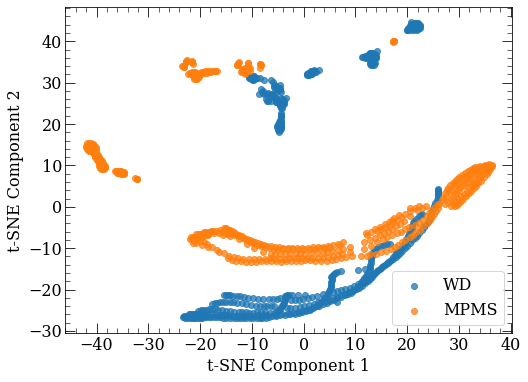

In [25]:
features = ['a_fwhm', 'a_height',
       'b_fwhm', 'b_height',
       'g_fwhm', 'g_height',
         'd_fwhm', 'd_height']

X = np.array(fdf[features])
t = np.array(fdf['mpms'])

tsne = TSNE(n_components = 2, perplexity = 35)
X_emb = tsne.fit_transform(X)

plt.figure(figsize = (8,6))
plt.scatter(X_emb[:, 0][t == 0], X_emb[:, 1][t == 0], label = 'WD', alpha = 0.75)
plt.scatter(X_emb[:, 0][t == 1], X_emb[:, 1][t == 1], label = 'MPMS', alpha = 0.75)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

In [26]:
balmer_array = np.array(fulldf[features])

In [27]:
arr1 = balmer_array[::2]
arr2 = balmer_array[1::2]

In [28]:
balmer_array = np.vstack((arr1, arr2))

In [29]:
np.savetxt('tables/balmer_features.txt', balmer_array)

## Logistic Regression

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [31]:
len(fdf)

1000

In [32]:
X = np.array(fdf[features])
t = np.array(fdf['mpms'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [34]:
lr = LogisticRegression(C = 0.1, tol = 1e-8, penalty = 'l2',
                       max_iter = 100000, n_jobs = -1)

In [35]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=100000, n_jobs=-1, tol=1e-08)

In [36]:
lr.score(X_test, y_test)

0.88

In [37]:
pickle.dump(lr, open('LR/spec_lr.p', 'wb'))

In [38]:
lr.coef_

array([[-0.382525  ,  0.37906052, -0.10316518,  1.01346226,  0.27820328,
         1.93829258,  0.05866965,  0.97501012]])

In [39]:
lr.intercept_

array([1.79466012])

In [40]:
features

['a_fwhm',
 'a_height',
 'b_fwhm',
 'b_height',
 'g_fwhm',
 'g_height',
 'd_fwhm',
 'd_height']